In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from io import StringIO
import sys, os
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet, create_full_tear_sheet)

sys.path.insert(1, os.path.join(sys.path[0], '..'))
sns.set_style('whitegrid')
YEAR = 252
idx = pd.IndexSlice

scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
catboost_train_params = ['max_depth', 'min_child_samples']

results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [2]:
# LightGBM - Summary Metrics by Fold
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate([k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {'lookahead': t,'train_length': train_length,'test_length': test_length}
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), id_vars=id_vars, value_name='ic',
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          4225 non-null   int64  
 1   train_length       4225 non-null   int64  
 2   test_length        4225 non-null   int64  
 3   learning_rate      4225 non-null   float64
 4   num_leaves         4225 non-null   float64
 5   feature_fraction   4225 non-null   float64
 6   min_data_in_leaf   4225 non-null   float64
 7   daily_ic_mean      4225 non-null   float64
 8   daily_ic_mean_n    4225 non-null   float64
 9   daily_ic_median    4225 non-null   float64
 10  daily_ic_median_n  4225 non-null   float64
 11  boost_rounds       4225 non-null   int64  
 12  ic                 4225 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 429.2 KB


In [3]:
lgb_metrics.tail()

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
4220,1,1134,63,0.01,128.0,0.95,500.0,0.020720,500.0,0.019338,500.0,500,0.036446
4221,1,1134,63,0.01,128.0,0.60,250.0,0.015275,500.0,0.019475,400.0,500,0.018834
4222,1,1134,63,0.01,128.0,0.60,500.0,0.017191,500.0,0.023005,200.0,500,0.022895
4223,1,1134,63,0.01,128.0,0.30,250.0,0.014159,25.0,0.021043,250.0,500,0.019044
4224,1,1134,63,0.01,128.0,0.30,500.0,0.017466,250.0,0.016341,400.0,500,0.019428


In [4]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             702
           1134          63             702
5          252           63             702
           1134          63             702
21         252           63             702
           1134          63             715
dtype: int64

In [5]:
# Information Coefficient by Day
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        # print(key)
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key].drop(['boosting', 'objective', 'verbose', 'device_type', 'num_threads'], axis=1)
                 .assign(lookahead=t, train_length=train_length, test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, id_vars=id_vars, value_name='ic', var_name='boost_rounds').dropna()

# lgb_ic = lgb_ic.drop(lgb_ic[lgb_ic.boost_rounds=='device_type'].index)
# lgb_ic = lgb_ic.drop(lgb_ic[lgb_ic.boost_rounds=='num_threads'].index)
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121606 entries, 0 to 2129399
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              2121606 non-null  datetime64[ns]
 1   lookahead         2121606 non-null  int32         
 2   train_length      2121606 non-null  int32         
 3   test_length       2121606 non-null  int32         
 4   learning_rate     2121606 non-null  float64       
 5   num_leaves        2121606 non-null  int64         
 6   feature_fraction  2121606 non-null  float64       
 7   min_data_in_leaf  2121606 non-null  int64         
 8   boost_rounds      2121606 non-null  int32         
 9   ic                2121606 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(2)
memory usage: 145.7 MB


In [6]:
lgb_ic.tail()

,date,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
2129395,2016-12-23,1,1134,63,0.01,128,0.3,500,500,0.092552
2129396,2016-12-27,1,1134,63,0.01,128,0.3,500,500,-0.031668
2129397,2016-12-28,1,1134,63,0.01,128,0.3,500,500,-0.116470
2129398,2016-12-29,1,1134,63,0.01,128,0.3,500,500,-0.073259
2129399,2016-12-30,1,1134,63,0.01,128,0.3,500,500,0.213865


In [7]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         4225 non-null   int64  
 1   train_length      4225 non-null   int64  
 2   test_length       4225 non-null   int64  
 3   learning_rate     4225 non-null   float64
 4   num_leaves        4225 non-null   int64  
 5   feature_fraction  4225 non-null   float64
 6   min_data_in_leaf  4225 non-null   int64  
 7   boost_rounds      4225 non-null   int64  
 8   ic                4225 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 297.2 KB


In [8]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

In [9]:
lgb_ic.shape, lgb_daily_ic.shape

((2121606, 10), (4225, 9))

In [10]:
# CatBoost - Summary Metrics
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    for i, key in enumerate([k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {'lookahead'   : t, 'train_length': train_length, 'test_length' : test_length }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            catboost_metrics = pd.Series(s).to_frame(i)
        else:
            catboost_metrics[i] = pd.Series(s)

id_vars = scope_params + catboost_train_params + daily_ic_metrics
catboost_metrics = pd.melt(catboost_metrics.T.drop('t', axis=1), id_vars=id_vars, value_name='ic',
                           var_name='boost_rounds').dropna().apply(pd.to_numeric)
catboost_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     float64
 4   min_child_samples  84 non-null     float64
 5   daily_ic_mean      84 non-null     float64
 6   daily_ic_mean_n    84 non-null     float64
 7   daily_ic_median    84 non-null     float64
 8   daily_ic_median_n  84 non-null     float64
 9   boost_rounds       84 non-null     int64  
 10  ic                 84 non-null     float64
dtypes: float64(7), int64(4)
memory usage: 7.3 KB


In [11]:
id_vars

['lookahead',
 'train_length',
 'test_length',
 'max_depth',
 'min_child_samples',
 'daily_ic_mean',
 'daily_ic_mean_n',
 'daily_ic_median',
 'daily_ic_median_n']

In [12]:
catboost_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             14
           1134          63             14
5          252           63             14
           1134          63             14
21         252           63             14
           1134          63             14
dtype: int64

In [13]:
# Daily Information Coefficient
catboost_ic = []
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key].drop(['task_type', 'thread_count'], axis=1)
                 .assign(lookahead=t, train_length=train_length, test_length=test_length))
            catboost_ic.append(df)
    catboost_ic = pd.concat(catboost_ic).reset_index()

id_vars = ['date'] + scope_params + catboost_train_params
catboost_ic = pd.melt(catboost_ic, id_vars=id_vars, value_name='ic', var_name='boost_rounds').dropna()
catboost_ic.loc[:, int_cols] = catboost_ic.loc[:, int_cols].astype(int)
catboost_ic.to_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42336 entries, 0 to 42335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               42336 non-null  datetime64[ns]
 1   lookahead          42336 non-null  int32         
 2   train_length       42336 non-null  int32         
 3   test_length        42336 non-null  int32         
 4   max_depth          42336 non-null  int64         
 5   min_child_samples  42336 non-null  int64         
 6   boost_rounds       42336 non-null  int32         
 7   ic                 42336 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(4), int64(2)
memory usage: 1.9 MB


In [14]:
catboost_ic.tail()

,date,lookahead,train_length,test_length,max_depth,min_child_samples,boost_rounds,ic
42331,2016-12-23,1,1134,63,7,500,1000,0.008398
42332,2016-12-27,1,1134,63,7,500,1000,-0.083045
42333,2016-12-28,1,1134,63,7,500,1000,-0.043935
42334,2016-12-29,1,1134,63,7,500,1000,-0.106680
42335,2016-12-30,1,1134,63,7,500,1000,-0.014306


In [15]:
catboost_daily_ic = catboost_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
catboost_daily_ic.to_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     int64  
 4   min_child_samples  84 non-null     int64  
 5   boost_rounds       84 non-null     int64  
 6   ic                 84 non-null     float64
dtypes: float64(1), int64(6)
memory usage: 4.7 KB


In [16]:
catboost_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')

In [17]:
catboost_ic.shape, catboost_daily_ic.shape

((42336, 8), (84, 7))

Text(0.5, 1.0, 'Daily IC')

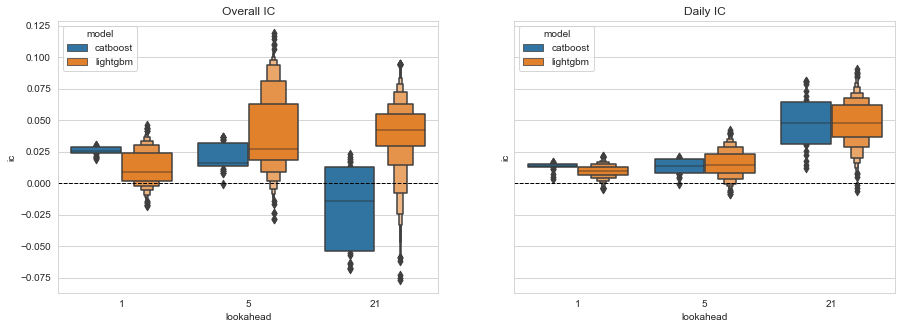

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model', data=catboost_metrics.assign(model='catboost')
              .append(lgb_metrics.assign(model='lightgbm')), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model', data=catboost_daily_ic.assign(model='catboost')
              .append(lgb_daily_ic.assign(model='lightgbm')), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')

In [19]:
lgb_ic['ic'] = lgb_ic['ic'].astype(float)
lgb_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121606 entries, 0 to 2129399
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   lookahead         int32         
 2   train_length      int32         
 3   test_length       int32         
 4   learning_rate     float64       
 5   num_leaves        int64         
 6   feature_fraction  float64       
 7   min_data_in_leaf  int64         
 8   boost_rounds      int32         
 9   ic                float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(2)
memory usage: 145.7 MB


In [20]:
lgb_ic.tail()

,date,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
2129395,2016-12-23,1,1134,63,0.01,128,0.3,500,500,0.092552
2129396,2016-12-27,1,1134,63,0.01,128,0.3,500,500,-0.031668
2129397,2016-12-28,1,1134,63,0.01,128,0.3,500,500,-0.116470
2129398,2016-12-29,1,1134,63,0.01,128,0.3,500,500,-0.073259
2129399,2016-12-30,1,1134,63,0.01,128,0.3,500,500,0.213865


In [21]:
# HyperParameter Impact: Linear Regression
lin_reg = {}
for t in [1, 21]:
    df_ = lgb_ic[lgb_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))

    model = sm.OLS(endog=y.astype('float'), exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [22]:
coefs.tail()

,variable,coef,std_err,t,p_value,ci_low,ci_high
521,boost_rounds_300,0.0148,0.001,24.984,0.0,0.014,0.016
522,boost_rounds_350,0.0152,0.001,25.678,0.0,0.014,0.016
523,boost_rounds_400,0.0155,0.001,26.209,0.0,0.014,0.017
524,boost_rounds_450,0.0156,0.001,26.377,0.0,0.014,0.017
525,boost_rounds_500,0.0158,0.001,26.713,0.0,0.015,0.017


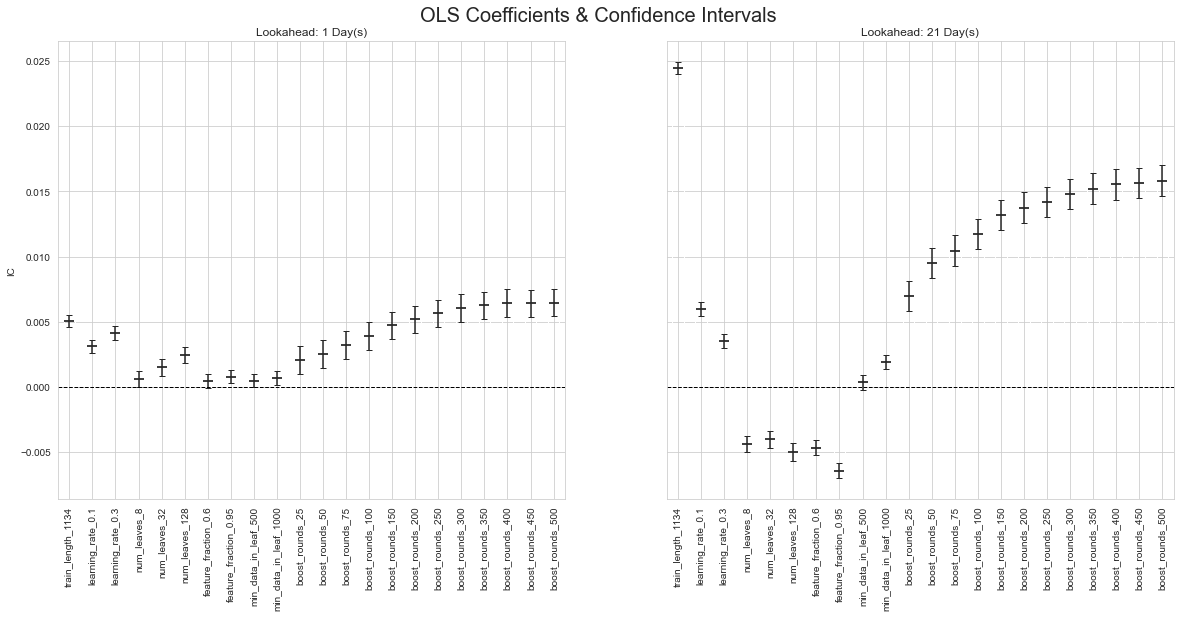

In [23]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, color='none', capsize=3, yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.subplots_adjust(top=.92);

In [24]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
284,1,1134,63,0.1,8.0,0.95,1000.0,0.021938,500.0,0.021723,450.0,10,0.007739
609,1,1134,63,0.1,8.0,0.95,1000.0,0.021938,500.0,0.021723,450.0,25,0.010298
934,1,1134,63,0.1,8.0,0.95,1000.0,0.021938,500.0,0.021723,450.0,50,0.019595
64,5,1134,63,0.3,4.0,0.30,500.0,0.042352,350.0,0.039625,350.0,10,0.043296
389,5,1134,63,0.3,4.0,0.30,500.0,0.042352,350.0,0.039625,350.0,25,0.062347
714,5,1134,63,0.3,4.0,0.30,500.0,0.042352,350.0,0.039625,350.0,50,0.059334
190,21,1134,63,0.1,4.0,0.30,500.0,0.090349,100.0,0.102099,100.0,10,0.030840
515,21,1134,63,0.1,4.0,0.30,500.0,0.090349,100.0,0.102099,100.0,25,0.077478
840,21,1134,63,0.1,4.0,0.30,500.0,0.090349,100.0,0.102099,100.0,50,0.091394


In [25]:
# 2) CatBoost
group_cols = scope_params + catboost_train_params + ['boost_rounds']
catboost_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,boost_rounds,ic
26,1,1134,63,7,500,900,0.017001
24,1,1134,63,7,500,700,0.016828
27,1,1134,63,7,500,1000,0.016115
47,5,1134,63,7,500,200,0.020629
42,5,1134,63,7,500,10,0.020533
49,5,1134,63,7,500,400,0.020096
73,21,1134,63,3,250,75,0.080961
72,21,1134,63,3,250,50,0.080872
74,21,1134,63,3,250,100,0.080600


In [26]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
41,1,1134,63,7.0,500.0,0.017001,900.0,0.016113,25.0,300,0.030404
35,1,1134,63,7.0,500.0,0.017001,900.0,0.016113,25.0,200,0.030306
29,1,1134,63,7.0,500.0,0.017001,900.0,0.016113,25.0,100,0.029629
72,5,252,63,7.0,250.0,0.010320,1000.0,0.021692,700.0,900,0.036959
78,5,252,63,7.0,250.0,0.010320,1000.0,0.021692,700.0,1000,0.036795
66,5,252,63,7.0,250.0,0.010320,1000.0,0.021692,700.0,800,0.036654
80,21,252,63,5.0,20.0,0.036175,300.0,0.042113,300.0,1000,0.023282
74,21,252,63,5.0,20.0,0.036175,300.0,0.042113,300.0,900,0.021039
68,21,252,63,5.0,20.0,0.036175,300.0,0.042113,300.0,800,0.019177


In [27]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
5,1,1134,63,7.0,500.0,0.017001,900.0,0.016113,25.0,10,0.025782
11,1,1134,63,7.0,500.0,0.017001,900.0,0.016113,25.0,25,0.023885
17,1,1134,63,7.0,500.0,0.017001,900.0,0.016113,25.0,50,0.027166
1,5,1134,63,7.0,500.0,0.020629,200.0,0.021534,200.0,10,0.007933
7,5,1134,63,7.0,500.0,0.020629,200.0,0.021534,200.0,25,0.011639
13,5,1134,63,7.0,500.0,0.020629,200.0,0.021534,200.0,50,0.015669
3,21,1134,63,3.0,250.0,0.080961,75.0,0.101297,75.0,10,-0.009786
9,21,1134,63,3.0,250.0,0.080961,75.0,0.101297,75.0,25,-0.003460
15,21,1134,63,3.0,250.0,0.080961,75.0,0.101297,75.0,50,-0.002020


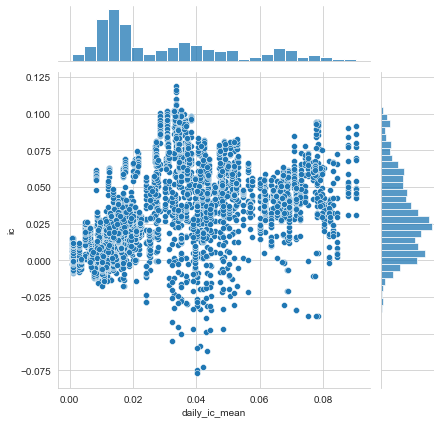

In [28]:
sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

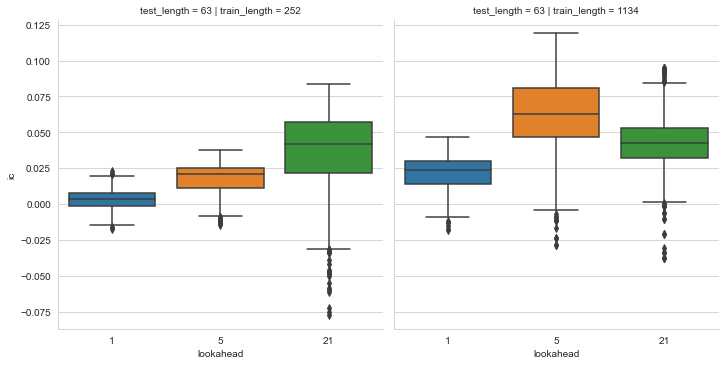

In [29]:
# Visualization
# 1) LightGBM
g = sns.catplot(x='lookahead', y='ic', col='train_length', row='test_length', data=lgb_metrics, kind='box')

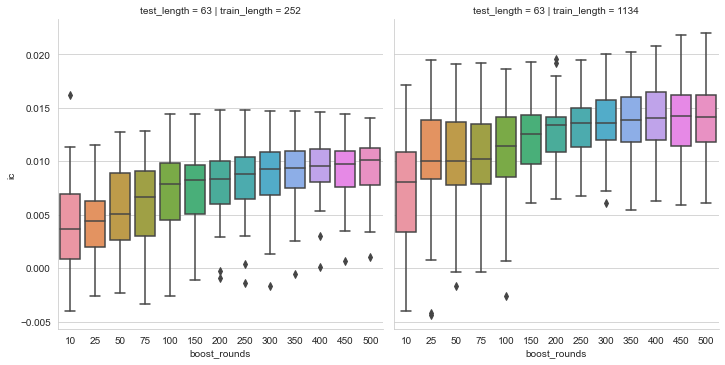

In [30]:
t=1
g=sns.catplot(x='boost_rounds', y='ic', col='train_length', row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t], kind='box')

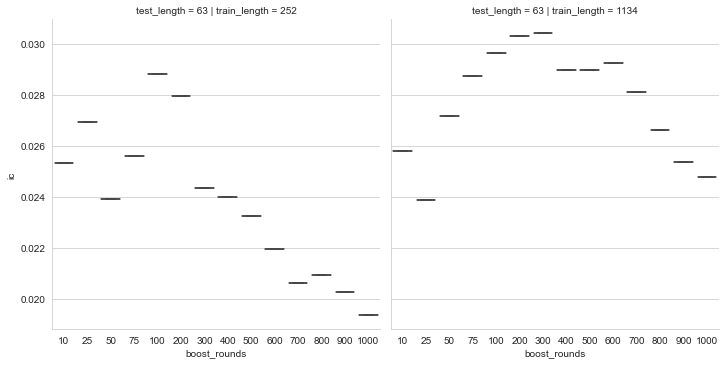

In [31]:
# 2) CatBoost
t = 1
g=sns.catplot(x='boost_rounds', y='ic', col='train_length', row='test_length',
            data=catboost_metrics[catboost_metrics.lookahead == t], kind='box')

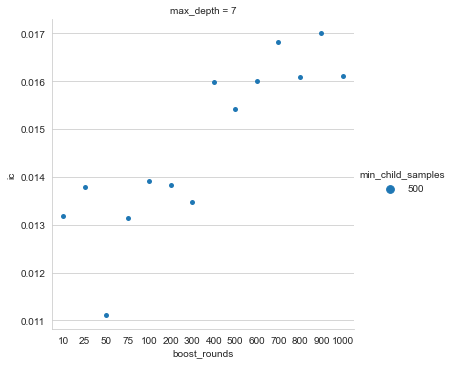

In [32]:
t = 1
train_length = 1134
test_length = 63
g = sns.catplot(x='boost_rounds', y='ic', col='max_depth', hue='min_child_samples',
    data=catboost_daily_ic[(catboost_daily_ic.lookahead == t) &
                      (catboost_daily_ic.train_length == train_length) &
                      (catboost_daily_ic.test_length == test_length)], kind='swarm')

In [33]:
# AlphaLens Analysis - Validation Performance
# 1) LightGBM
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 0 to 4224
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         4225 non-null   int64  
 1   train_length      4225 non-null   int64  
 2   test_length       4225 non-null   int64  
 3   learning_rate     4225 non-null   float64
 4   num_leaves        4225 non-null   int64  
 5   feature_fraction  4225 non-null   float64
 6   min_data_in_leaf  4225 non-null   int64  
 7   boost_rounds      4225 non-null   int64  
 8   ic                4225 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 330.1 KB


In [34]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        1134.00
test_length           63.00
learning_rate          0.10
num_leaves             8.00
feature_fraction       0.95
min_data_in_leaf    1000.00
boost_rounds         500.00
Name: 1091, dtype: float64

In [35]:
best_params.to_hdf('data/data.h5', 'best_params')

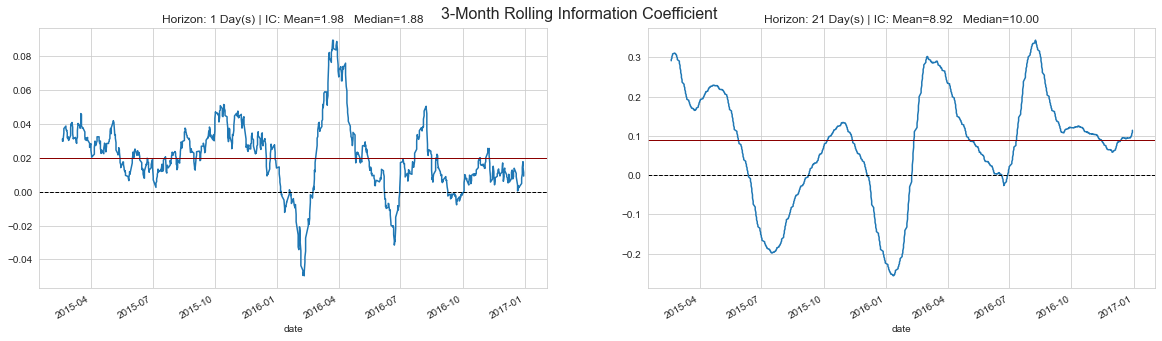

In [36]:
# Plot rolling IC
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.subplots_adjust(top=0.92);

In [68]:
# Get Predictions for Validation Period
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        print(f'key:{key}')
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        print(f'key:{key}')
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

key:1/1134/63/0.1/8/0.95/1000
key:1/1134/63/0.1/8/0.95/1000
key:1/1134/63/0.1/8/0.95/1000
key:1/1134/63/0.01/128/0.95/500
key:1/1134/63/0.01/128/0.95/500
key:1/1134/63/0.01/128/0.95/500
key:1/1134/63/0.1/8/0.95/1000
key:1/1134/63/0.1/4/0.6/500
key:1/1134/63/0.1/8/0.95/1000
key:1/1134/63/0.1/8/0.95/1000


In [38]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 484174 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       484174 non-null  float64
 1   1       484174 non-null  float64
 2   2       484174 non-null  float64
 3   3       484174 non-null  float64
 4   4       484174 non-null  float64
 5   5       484174 non-null  float64
 6   6       484174 non-null  float64
 7   7       484174 non-null  float64
 8   8       484174 non-null  float64
 9   9       484174 non-null  float64
dtypes: float64(10)
memory usage: 38.8+ MB


In [39]:
# Get Trade Prices
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = 'data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open'].unstack('symbol').sort_index().shift(-1)
            .tz_localize('UTC'))

test_tickers = best_predictions.index.get_level_values('symbol').unique()
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 961 entries, A to ZION
dtypes: float64(961)
memory usage: 5.5 MB


In [40]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [41]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

# Create AlphaLens Inputs
factor_data = get_clean_factor_and_forward_returns(factor=factor, prices=trade_prices, quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [42]:
# Compute Alphalens metrics
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(factor_data, by_date=True,
    by_group=False, demeaned=True, group_adjust=False,)
factor_returns = perf.factor_returns(factor_data)
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data, by_group=False, demeaned=True)

mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0, base_period=mean_quant_ret.columns[0])
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(factor_data, by_date=True,
    by_group=False, demeaned=True, group_adjust=False, )

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],)

compstd_quant_daily = std_quant_daily.apply(std_conversion, base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data, demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate, factor_data["factor_quantile"].max(), factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,)

mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,5D,10D,21D
Mean Period Wise Spread (bps),11.322415,6.543953,5.332393,4.822626
Ann. alpha,0.151882,0.074499,0.052424,0.044710
beta,0.098360,0.139858,0.172138,0.194793


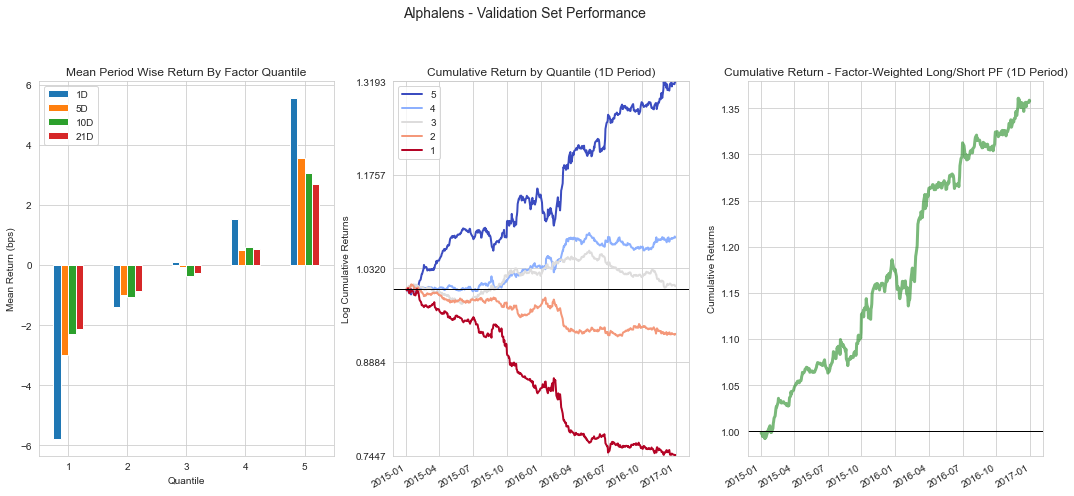

In [43]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 8))

plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'], freq=pd.tseries.offsets.BDay(),
                                             period='1D', ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'], period='1D', freq=pd.tseries.offsets.BDay(),
                                 title=title, ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.subplots_adjust(top=.85)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.046647,0.008842,-0.002157,0.003643,97153,20.065762
2,-0.015931,0.014083,-0.000712,0.003326,96765,19.985625
3,-0.012641,0.017630,0.000061,0.003393,96722,19.976744
4,-0.010292,0.021108,0.000808,0.003571,96765,19.985625
5,-0.008782,0.048559,0.002352,0.004463,96768,19.986245


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.152,0.074,0.052,0.045
beta,0.098,0.140,0.172,0.195
Mean Period Wise Return Top Quantile (bps),5.551,3.575,3.077,2.708
Mean Period Wise Return Bottom Quantile (bps),-5.772,-2.990,-2.284,-2.133
Mean Period Wise Spread (bps),11.322,6.544,5.332,4.823


Information Analysis


,1D,5D,10D,21D
IC Mean,0.018,0.022,0.027,0.044
IC Std.,0.124,0.134,0.137,0.133
Risk-Adjusted IC,0.148,0.165,0.195,0.330
t-stat(IC),3.317,3.711,4.389,7.399
p-value(IC),0.001,0.000,0.000,0.000
IC Skew,0.124,0.348,0.281,0.037
IC Kurtosis,0.981,1.224,0.638,0.687


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.580,0.637,0.701,0.754
Quantile 2 Mean Turnover,0.730,0.749,0.775,0.783
Quantile 3 Mean Turnover,0.748,0.764,0.781,0.788
Quantile 4 Mean Turnover,0.723,0.747,0.770,0.786
Quantile 5 Mean Turnover,0.572,0.627,0.684,0.725


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.407,0.311,0.195,0.099


<Figure size 432x288 with 0 Axes>

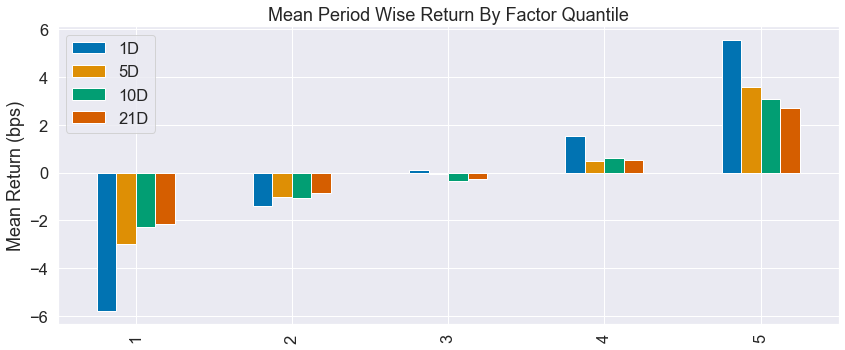

In [44]:
# Summary Tearsheet
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.046647,0.008842,-0.002157,0.003643,97153,20.065762
2,-0.015931,0.014083,-0.000712,0.003326,96765,19.985625
3,-0.012641,0.017630,0.000061,0.003393,96722,19.976744
4,-0.010292,0.021108,0.000808,0.003571,96765,19.985625
5,-0.008782,0.048559,0.002352,0.004463,96768,19.986245


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.152,0.074,0.052,0.045
beta,0.098,0.140,0.172,0.195
Mean Period Wise Return Top Quantile (bps),5.551,3.575,3.077,2.708
Mean Period Wise Return Bottom Quantile (bps),-5.772,-2.990,-2.284,-2.133
Mean Period Wise Spread (bps),11.322,6.544,5.332,4.823


<Figure size 432x288 with 0 Axes>

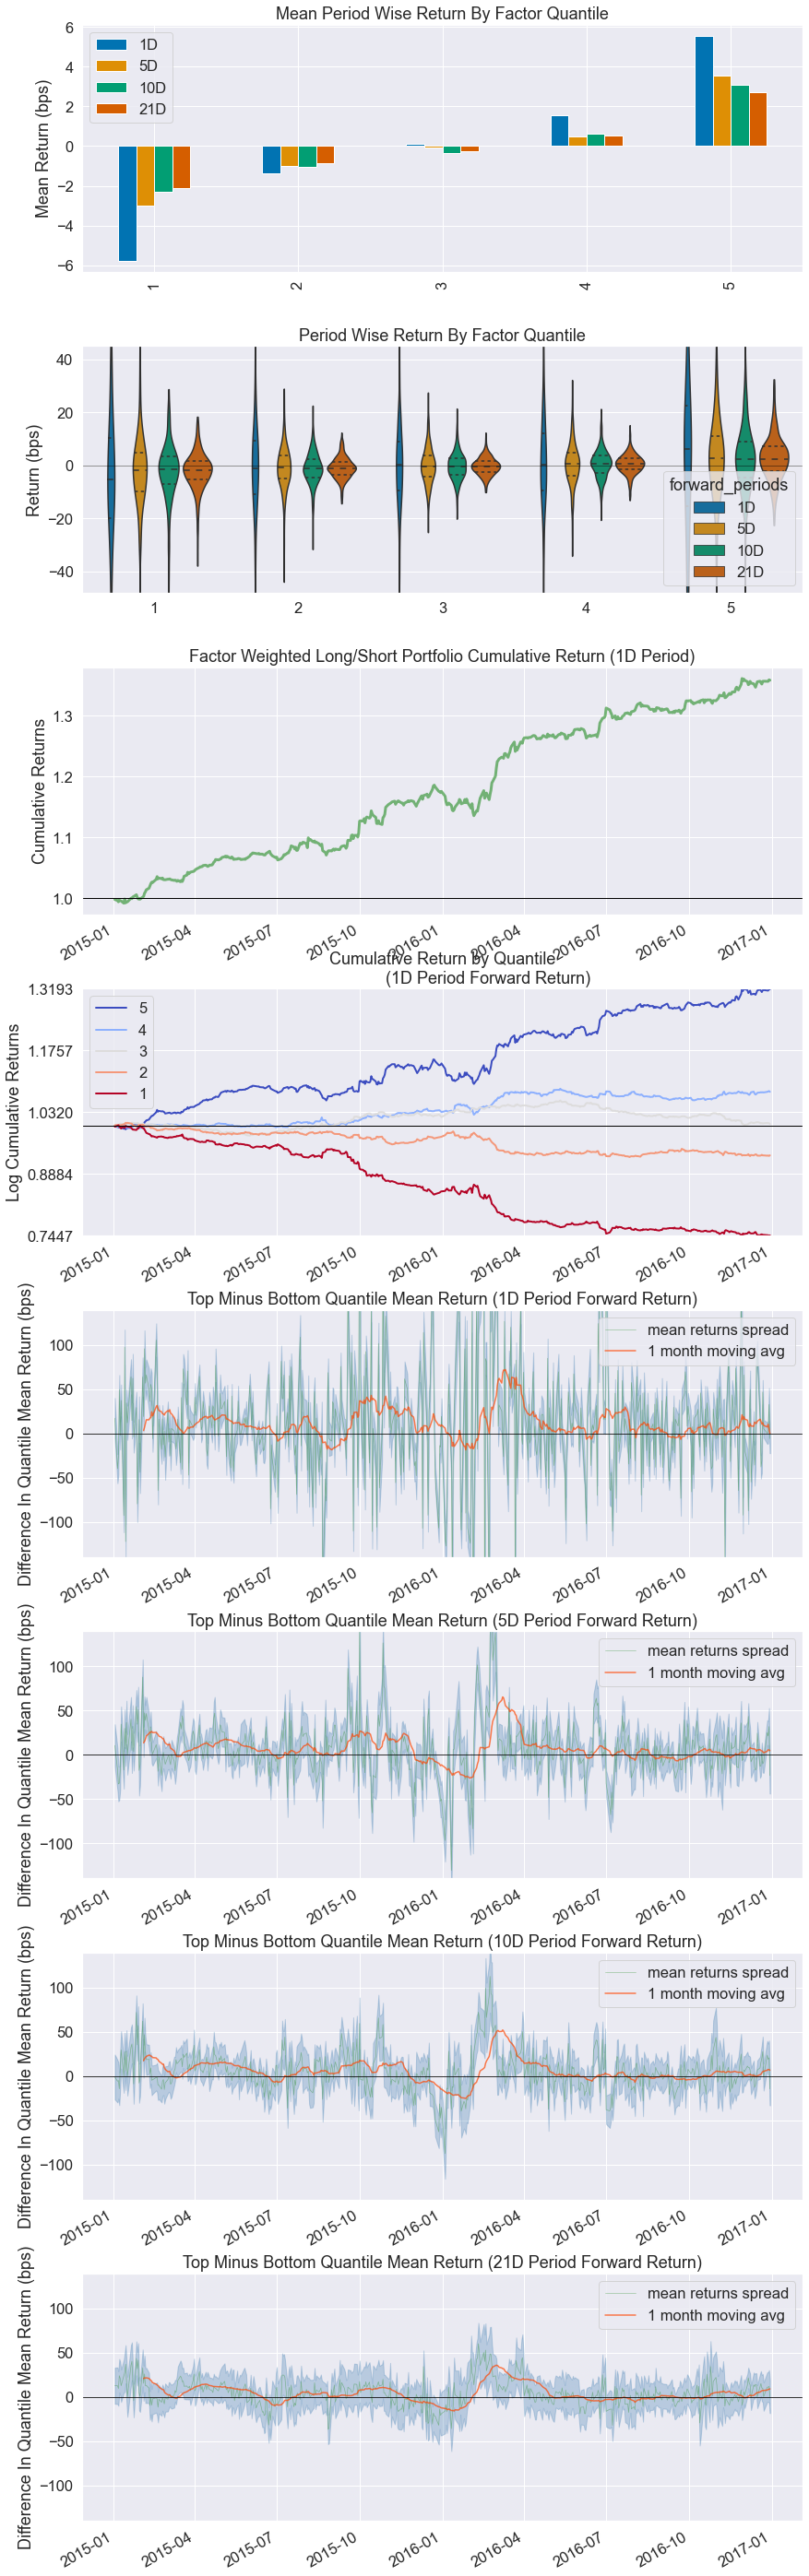

Information Analysis


,1D,5D,10D,21D
IC Mean,0.018,0.022,0.027,0.044
IC Std.,0.124,0.134,0.137,0.133
Risk-Adjusted IC,0.148,0.165,0.195,0.330
t-stat(IC),3.317,3.711,4.389,7.399
p-value(IC),0.001,0.000,0.000,0.000
IC Skew,0.124,0.348,0.281,0.037
IC Kurtosis,0.981,1.224,0.638,0.687


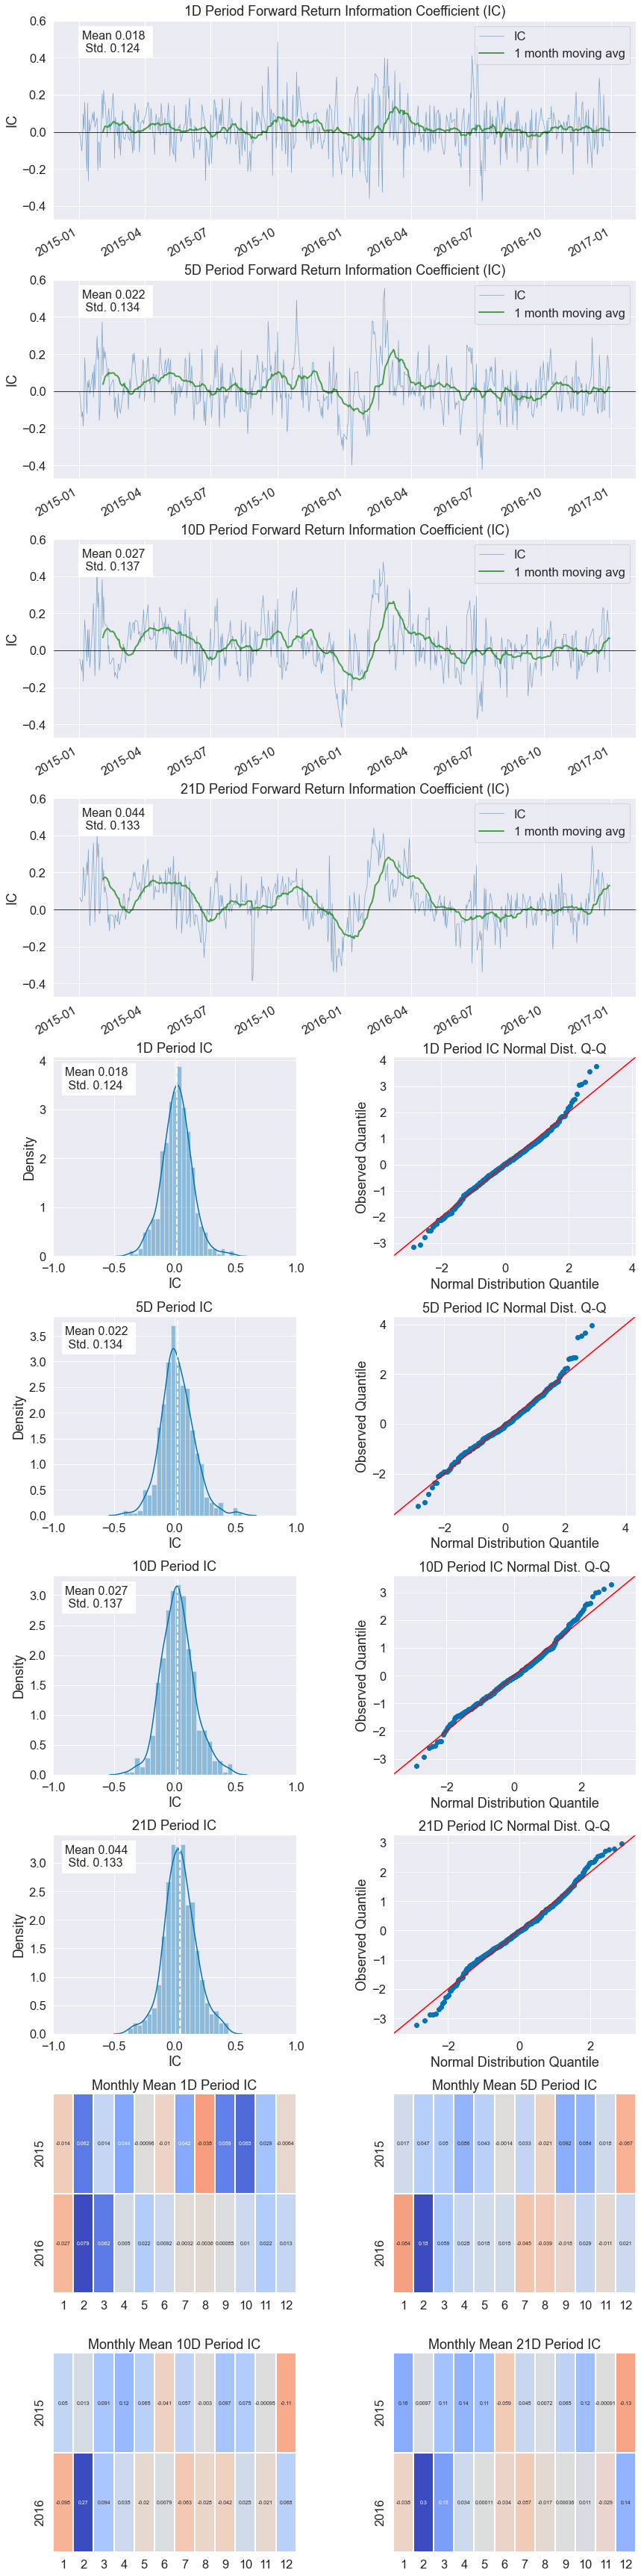

AttributeError: 'Index' object has no attribute 'get_values'

In [45]:
create_full_tear_sheet(factor_data)

In [46]:
# 2) CatBoost
# Select Parameters
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     int64  
 4   min_child_samples  84 non-null     int64  
 5   boost_rounds       84 non-null     int64  
 6   ic                 84 non-null     float64
dtypes: float64(1), int64(6)
memory usage: 5.2 KB


In [54]:
catboost_daily_ic

,lookahead,train_length,test_length,max_depth,min_child_samples,boost_rounds,ic
0,1,252,63,5,250,10,0.003365
1,1,252,63,5,250,25,0.004839
2,1,252,63,5,250,50,0.007281
3,1,252,63,5,250,75,0.011019
4,1,252,63,5,250,100,0.013294
...,...,...,...,...,...,...,...
79,21,1134,63,3,250,600,0.063070
80,21,1134,63,3,250,700,0.064036
81,21,1134,63,3,250,800,0.059813
82,21,1134,63,3,250,900,0.059231


In [70]:
def get_cb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + catboost_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    # print(f'df:{df.loc[param_cols]}')
    return df.loc[param_cols]

def get_cb_key(t, p):
    return f'{t}/{int(p.train_length)}/{int(p.test_length)}' # / {int(p.max_depth)}/{int(p.min_child_samples)}'

best_params = get_cb_params(catboost_daily_ic, t=1, best=0)
best_params

train_length         1134.0
test_length            63.0
max_depth               7.0
min_child_samples     500.0
boost_rounds          900.0
Name: 26, dtype: float64

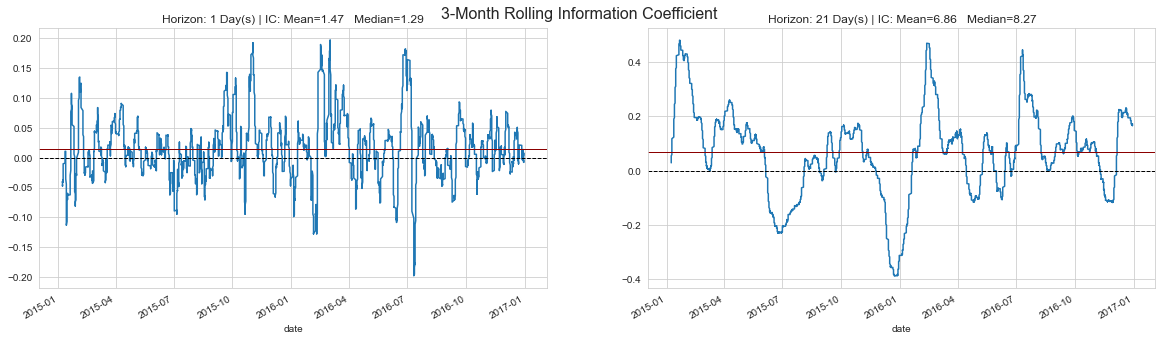

In [48]:
def select_cb_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.max_depth == params.max_depth) &
                       (ic_data.min_child_samples == params.min_child_samples)].set_index('date')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_cb_params(catboost_daily_ic, t=t)
    data = select_cb_ic(params, catboost_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.subplots_adjust(top=0.92)

In [71]:
# Get Predictions
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_cb_params(catboost_daily_ic, t=lookahead, best=best)
    key = get_cb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_catboost.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_catboost.h5', 'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [72]:
best_predictions

0         1         2         3         4         5  \
symbol date                                                                     
A      2015-01-02  0.007063  0.006703  0.007344  0.007151  0.006079  0.005362   
       2015-01-05  0.007170  0.005551  0.007003  0.006823  0.005768  0.006290   
       2015-01-06  0.012866  0.012514  0.012802  0.012286  0.012121  0.010930   
       2015-01-07  0.012452  0.011599  0.012120  0.012414  0.011575  0.010448   
       2015-01-08  0.002115  0.001967  0.002264  0.002017  0.001268  0.002166   
...                     ...       ...       ...       ...       ...       ...   
ZION   2016-12-23  0.001855  0.001945  0.001605  0.001940  0.001935  0.001556   
       2016-12-27 -0.002555 -0.002424 -0.002462 -0.002344 -0.002324 -0.001712   
       2016-12-28 -0.000521 -0.000578 -0.000128 -0.000246 -0.000794 -0.000545   
       2016-12-29 -0.000359 -0.000203 -0.000486 -0.000273 -0.000206  0.000203   
       2016-12-30  0.001923  0.002358  0.001910  0.002120  0.002268  0.001984   

                          6         7         8         9  
symbol date                                                
A      2015-01-02  0.005700 -0.007077 -0.008376 -0.008202  
       2015-01-05  0.005676  0.009173  0.009251  0.009000  
       2015-01-06  0.011403  0.003922  0.004527  0.004525  
       2015-01-07  0.010338  0.001939  0.001676  0.002215  
       2015-01-08  0.001976 -0.004623 -0.004273 -0.004485  
...                     ...       ...       ...       ...  
ZION   2016-12-23  0.002072 -0.000893 -0.001594 -0.001522  
       2016-12-27 -0.001765 -0.004541 -0.005605 -0.004953  
       2016-12-28 -0.000587 -0.006649 -0.006614 -0.006440  
       2016-12-29  0.000055 -0.004400 -0.004447 -0.004517  
       2016-12-30  0.002202 -0.002769 -0.004057 -0.003969  

[484174 rows x 10 columns]

In [73]:
best_predictions.to_hdf('data/predictions.h5', f'catboost/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 484174 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       484174 non-null  float64
 1   1       484174 non-null  float64
 2   2       484174 non-null  float64
 3   3       484174 non-null  float64
 4   4       484174 non-null  float64
 5   5       484174 non-null  float64
 6   6       484174 non-null  float64
 7   7       484174 non-null  float64
 8   8       484174 non-null  float64
 9   9       484174 non-null  float64
dtypes: float64(10)
memory usage: 38.8+ MB


In [75]:
# Get Trade Prices
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = 'data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open'].unstack('symbol').sort_index().shift(-1)
            .tz_localize('UTC'))

test_tickers = best_predictions.index.get_level_values('symbol').unique()
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 961 entries, A to ZION
dtypes: float64(961)
memory usage: 5.5 MB


In [76]:
trade_prices.tail()

symbol,A,AAL,AAN,AAPL,ABC,ABMD,ABT,ACC,ACGL,ACIW,...,XEL,XL,XLNX,XOM,XPO,XRAY,XRX,YUM,ZBRA,ZION
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22 00:00:00+00:00,67.31,52.35,40.15,170.80,92.48,191.31,57.01,40.35,89.53,22.36,...,48.18,35.26,67.52,83.96,88.99,65.98,29.51,82.39,104.89,51.25
2017-12-26 00:00:00+00:00,67.21,52.80,40.61,170.10,93.18,189.96,57.09,40.85,90.26,22.44,...,47.68,35.22,67.74,83.99,89.00,66.36,29.42,82.34,104.77,50.78
2017-12-27 00:00:00+00:00,67.44,52.45,40.52,171.00,92.88,190.50,57.44,40.70,90.56,22.45,...,47.92,35.30,68.00,83.98,91.65,66.16,29.25,82.69,105.13,50.92
2017-12-28 00:00:00+00:00,67.50,52.42,40.22,170.52,92.89,190.56,57.60,41.01,90.99,22.60,...,48.11,35.45,68.50,84.00,91.60,66.30,29.40,82.64,104.33,51.28
2017-12-29 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# only generate once to save time
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [78]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [79]:
# Create AlphaLens Inputs
factor_data = get_clean_factor_and_forward_returns(factor=factor, prices=trade_prices, quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.076653,0.016558,-0.003702,0.005747,97153,20.065762
2,-0.019302,0.029118,-0.000789,0.005087,96765,19.985625
3,-0.016290,0.038361,0.000738,0.005503,96722,19.976744
4,-0.013819,0.046258,0.002310,0.006196,96765,19.985625
5,-0.012110,0.098881,0.005566,0.008266,96768,19.986245


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.140,0.054,0.043,0.049
beta,0.055,0.101,0.127,0.143
Mean Period Wise Return Top Quantile (bps),4.722,2.374,2.254,2.522
Mean Period Wise Return Bottom Quantile (bps),-4.758,-1.840,-1.338,-1.700
Mean Period Wise Spread (bps),9.480,4.202,3.571,4.207


Information Analysis


,1D,5D,10D,21D
IC Mean,0.015,0.014,0.017,0.036
IC Std.,0.120,0.125,0.129,0.125
Risk-Adjusted IC,0.129,0.112,0.133,0.290
t-stat(IC),2.896,2.516,2.977,6.513
p-value(IC),0.004,0.012,0.003,0.000
IC Skew,0.092,-0.002,-0.031,0.083
IC Kurtosis,1.484,2.389,1.222,1.091


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.642,0.685,0.735,0.769
Quantile 2 Mean Turnover,0.755,0.766,0.783,0.791
Quantile 3 Mean Turnover,0.772,0.776,0.784,0.788
Quantile 4 Mean Turnover,0.754,0.767,0.782,0.790
Quantile 5 Mean Turnover,0.637,0.675,0.729,0.761


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.29,0.212,0.107,0.043


<Figure size 432x288 with 0 Axes>

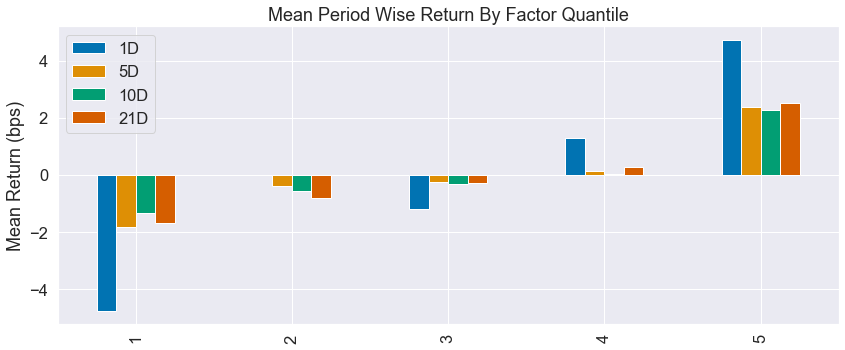

In [80]:
# Summary Tearsheet
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.076653,0.016558,-0.003702,0.005747,97153,20.065762
2,-0.019302,0.029118,-0.000789,0.005087,96765,19.985625
3,-0.016290,0.038361,0.000738,0.005503,96722,19.976744
4,-0.013819,0.046258,0.002310,0.006196,96765,19.985625
5,-0.012110,0.098881,0.005566,0.008266,96768,19.986245


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.140,0.054,0.043,0.049
beta,0.055,0.101,0.127,0.143
Mean Period Wise Return Top Quantile (bps),4.722,2.374,2.254,2.522
Mean Period Wise Return Bottom Quantile (bps),-4.758,-1.840,-1.338,-1.700
Mean Period Wise Spread (bps),9.480,4.202,3.571,4.207


<Figure size 432x288 with 0 Axes>

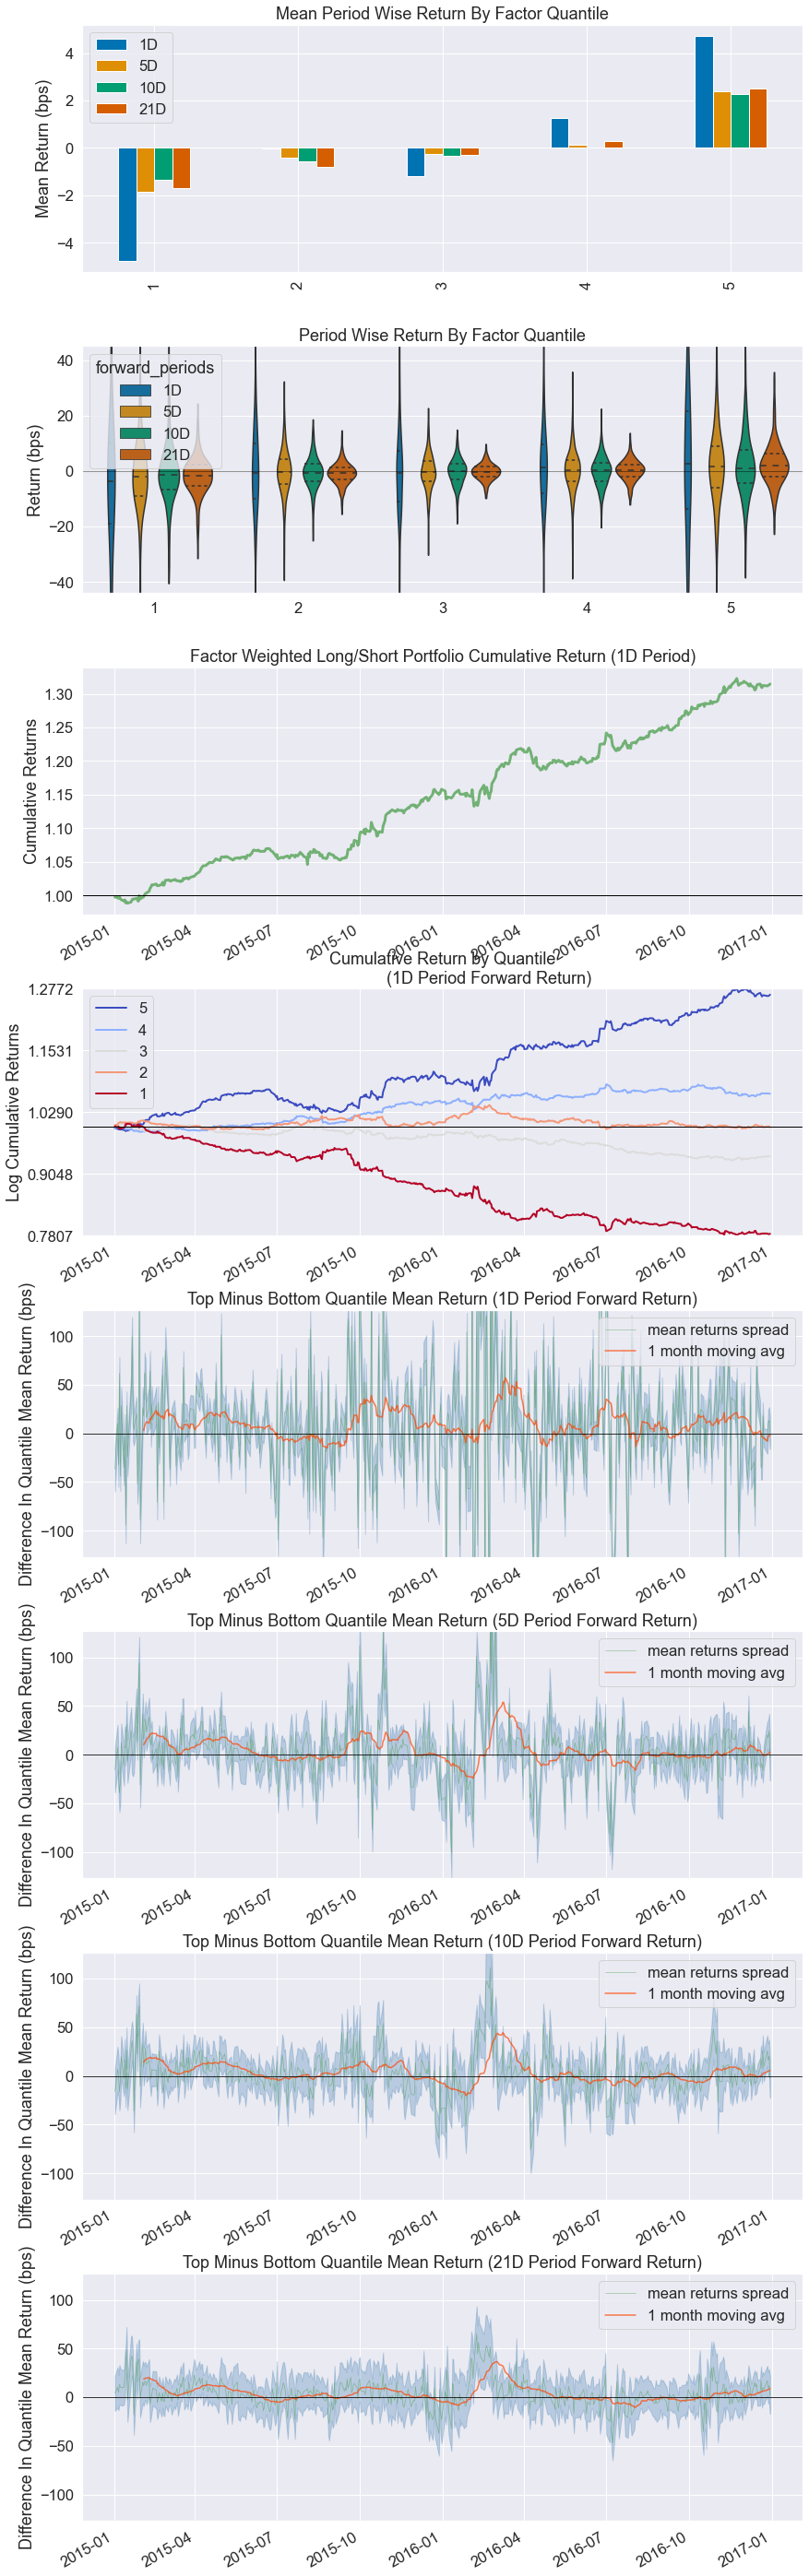

Information Analysis


,1D,5D,10D,21D
IC Mean,0.015,0.014,0.017,0.036
IC Std.,0.120,0.125,0.129,0.125
Risk-Adjusted IC,0.129,0.112,0.133,0.290
t-stat(IC),2.896,2.516,2.977,6.513
p-value(IC),0.004,0.012,0.003,0.000
IC Skew,0.092,-0.002,-0.031,0.083
IC Kurtosis,1.484,2.389,1.222,1.091


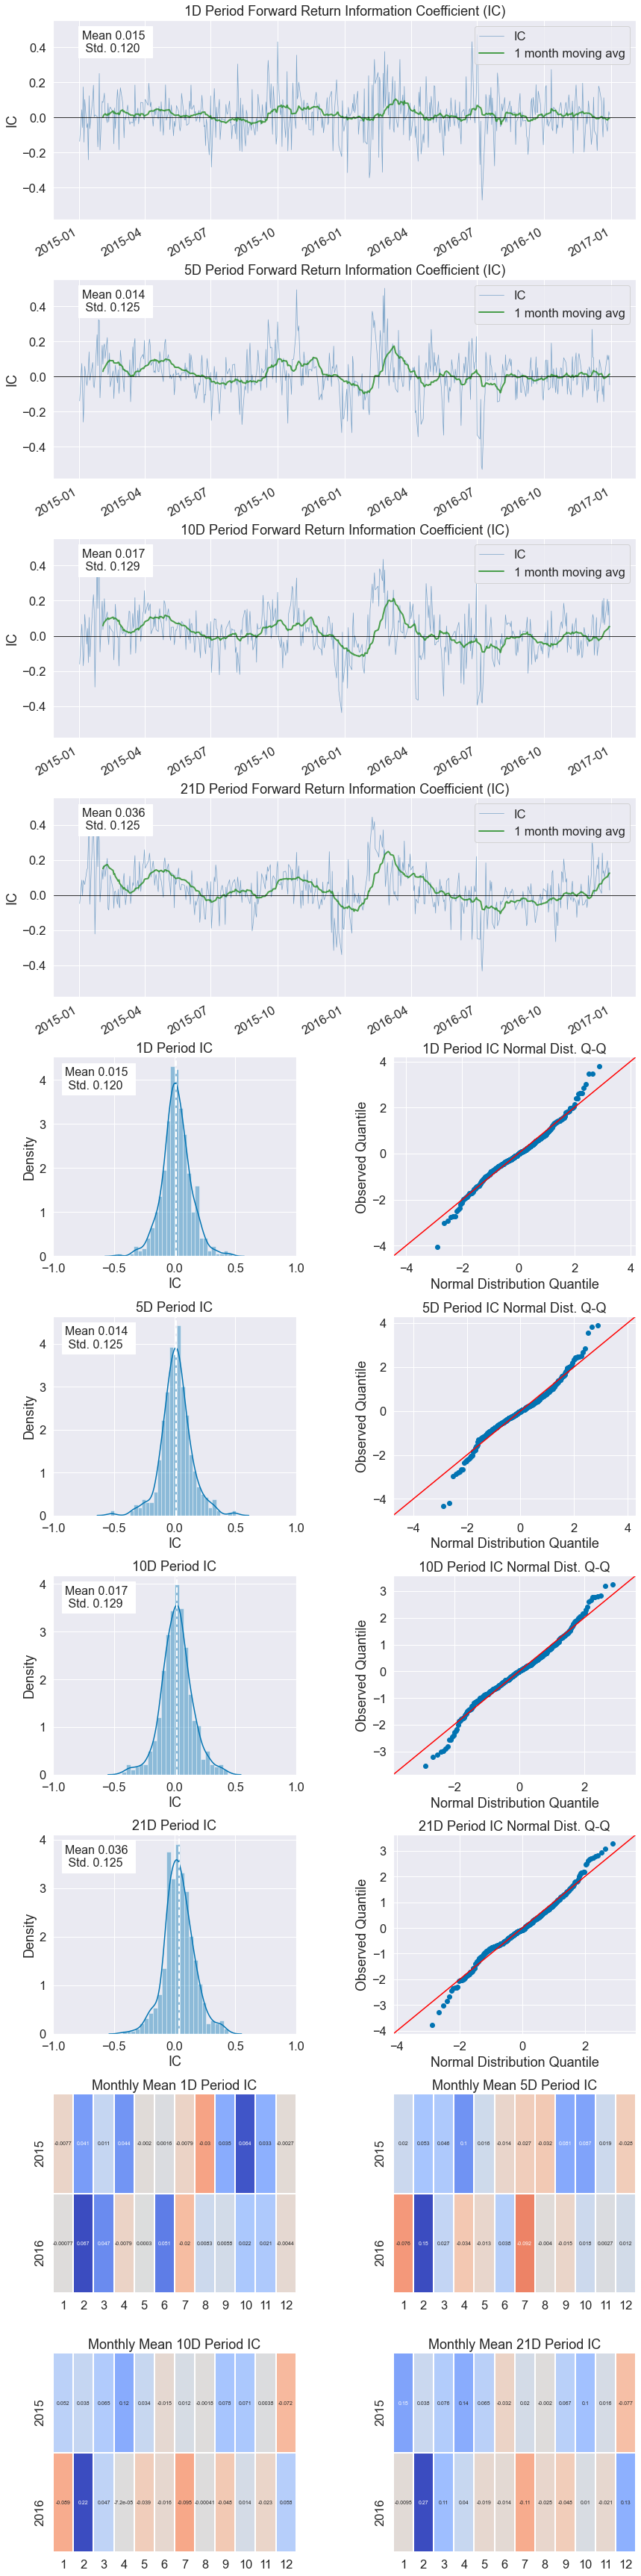

AttributeError: 'Index' object has no attribute 'get_values'

In [81]:
create_full_tear_sheet(factor_data)